1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


(3, 1000)
[[-0.05994848  0.18367722 -1.78907237 ... -0.41806065 -1.66528471
   0.84056182]
 [-2.29228237 -1.21447508  3.29301762 ...  2.71149398 -5.24770076
   2.47420197]
 [-2.41217933 -0.84712063 -0.28512711 ...  1.87537268 -8.57827019
   4.15532562]]
Eigenvalues and eigenvectors using la.eig: 

[ 2.63047424e+01 -1.03543290e-15  1.99373409e+00]
[[-0.11166553 -0.81649658  0.56644871]
 [-0.58208963 -0.40824829 -0.70321049]
 [-0.80542068  0.40824829  0.42968693]]
Eigenvalues and eigenvectors using la.svd: 

[2.63047424e+01 1.99373409e+00 4.15232647e-16] 

[[-0.11166553  0.56644871 -0.81649658]
 [-0.58208963 -0.70321049 -0.40824829]
 [-0.80542068  0.42968693  0.40824829]]
Test if the obtained values are equal to the ones obtained before:
True
True
[[ 2.63047424e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.03543290e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.99373409e+00]]
Variable  0  :  0.9295462393849405
Variable  1  :  -3.6589704613825616e-17
Variable  2  : 

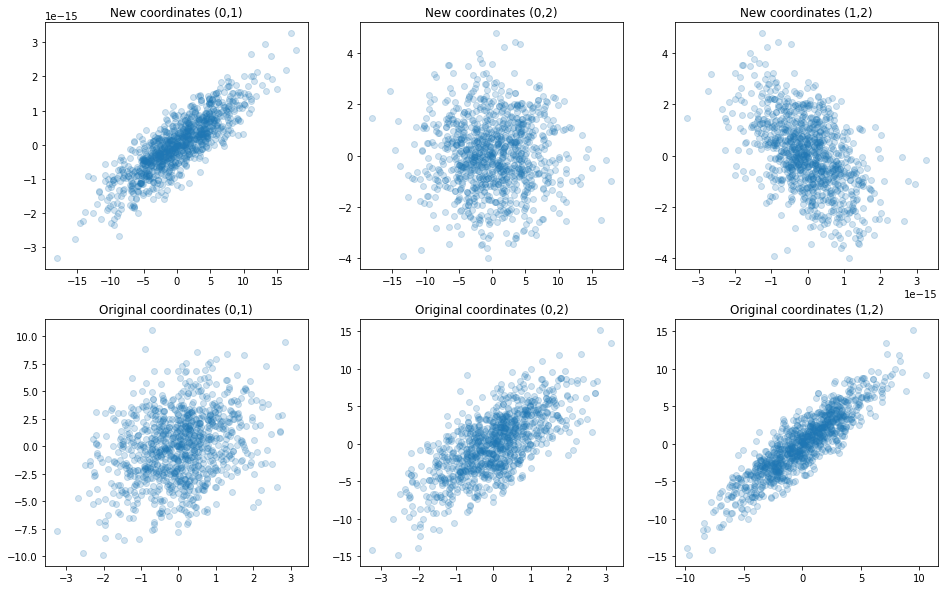

In [95]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
mu, sigma, n = 0, 1, 1000 # mean and standard deviation
x1 = np.random.normal(mu, sigma, n)
mu, sigma, n = 0, 3, 1000 # mean and standard deviation
x2 = x1 + np.random.normal(mu, sigma, n)
x3 = 2*x1+x2

dataset = np.array([x1, x2, x3])
print(dataset.shape)
print(dataset)
# eigenvectors of the covariance matrix
l, V = la.eig(np.cov(dataset))

print('Eigenvalues and eigenvectors using la.eig: \n')
print (np.real_if_close(l))   
print (V)

U, spectrum, Vt = la.svd(np.cov(dataset))
print('Eigenvalues and eigenvectors using la.svd: \n')

print (spectrum,'\n')
print (U)
print('Test if the obtained values are equal to the ones obtained before:')
# There is a diference betwin the obtained becouse of the order of the vectors, but this doesn't really matter
print(np.allclose(np.real_if_close(l), spectrum[[0,2,1]]))
print(np.allclose(V, U[:,[0,2,1]]))

l, V = np.linalg.eig(np.cov(dataset))
Lambda=np.diag(l)
print (Lambda)

for i in range(0, len(Lambda)):
    print ('Variable ',i, ' : ', Lambda[i,i]/Lambda.trace())

#The variable with less significance is x2, this make sense because x2 can be obtained by a linear conbination of x1 and x3
# If you exchange the positions of the variable x2 and x3, aparently the one that now doesen't have meaning is x3, this is 
# probably becouse of the implementation of the method, but anyway, it makes sense that one of the variables doesent have a 
# true significance because can be obtained by the linear combination of the others

reduced_dataset = np.delete(dataset, 1, 0)
print(reduced_dataset)


# Data with new basis
Xp = np.dot(V.T, dataset)
# plotting the data
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(2,3, 1)
ax.set_title('New coordinates (0,1)')
ax.scatter(Xp[0,:], Xp[1,:], alpha=0.2)
ax = fig.add_subplot(2,3, 2)
ax.set_title('New coordinates (0,2)')
ax.scatter(Xp[0,:], Xp[2,:], alpha=0.2)
ax = fig.add_subplot(2,3, 3)
ax.set_title('New coordinates (1,2)')
ax.scatter(Xp[1,:], Xp[2,:], alpha=0.2)

ax = fig.add_subplot(2,3, 4)
ax.set_title('Original coordinates (0,1)')
ax.scatter(dataset[0,:], dataset[1,:], alpha=0.2)
ax = fig.add_subplot(2,3, 5)
ax.set_title('Original coordinates (0,2)')
ax.scatter(dataset[0,:], dataset[2,:], alpha=0.2)
ax = fig.add_subplot(2,3, 6)
ax.set_title('Original coordinates (1,2)')
ax.scatter(dataset[1,:], dataset[2,:], alpha=0.2)

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [96]:
for i in range(1,11):
    x = np.random.normal(mu, sigma/50, n)
    dataset = np.vstack((dataset,x))
print(dataset.shape)

(13, 1000)


In [97]:
l, V = np.linalg.eig(np.cov(dataset))
Lambda=np.diag(l)
# print (Lambda)
print(len(Lambda))

for i in range(0, len(Lambda)):
    print ('Variable ',i, ' : ', Lambda[i,i]/Lambda.trace())

# As espected, one of the original variables have an extremely low significance (because it's just a linear combination of the
# others), the rest of the variables have a very low significnace as it was wxpected due to be just noise.



13
Variable  0  :  0.9283851123313448
Variable  1  :  0.07036714998738912
Variable  2  :  -1.3624461824680473e-17
Variable  3  :  0.0001469499446295332
Variable  4  :  0.0001415864708482462
Variable  5  :  0.0001344473751645156
Variable  6  :  0.00010841152741826138
Variable  7  :  0.00010917040421369477
Variable  8  :  0.00011242715928617531
Variable  9  :  0.00011725855465936013
Variable  10  :  0.0001289701047648096
Variable  11  :  0.00012283490957591193
Variable  12  :  0.0001256812307057474


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 